In [1]:
from pynq import Overlay
from pynq import allocate
from pynq import MMIO
import numpy as np
from time import time
from tqdm import tqdm
import cffi

ffi = cffi.FFI()

In [2]:
# Prepare the custome overlay and DMA
ol = Overlay("/home/xilinx/classifier.bit")
ol.download()

dma_mm2s = ol.axi_dma_0
dma_s2mm = ol.axi_dma_1

# Accelerator Base Address
ACCEL_CTRL = 0x43C00000

# Initialize HLS IP
mmult_ip = MMIO(ACCEL_CTRL, 0x10000)

# Start the accelerator
ctrl = mmult_ip.read(0x00) & 0x08
mmult_ip.write(0x00, (ctrl | 0x81))
ctrl = mmult_ip.read(0x00)
hex(ctrl)

'0x81'

In [3]:
# Classifier Dimensions
BATCH = 8192
FEAT = 256
CLASSES = 10

# Initialize offsets, weights and inputs
o = np.load('model_offsets_fixed.npy').astype(np.int32)
w = np.load('model_weights_fixed.npy').astype(np.int8)
i = np.load('test_data.npy').astype(np.uint8)[0:BATCH]
l = np.load('test_labels.npy').astype(np.int32)[0:BATCH]

In [4]:
mm2s_bufsz = CLASSES*4+CLASSES*FEAT+BATCH*FEAT
s2mm_bufsz = BATCH*CLASSES

In [5]:
# Move offset, weight and input data to DMA buffer
mm2s_buffer = allocate(shape=(mm2s_bufsz,), dtype=np.uint8)
s2mm_buffer = allocate(shape=(s2mm_bufsz,), dtype=np.int32)

ffi.memmove(mm2s_buffer[:], ffi.cast("uint8_t *", o.ctypes.data), CLASSES*4)
ffi.memmove(mm2s_buffer[CLASSES*4:], ffi.cast("uint8_t *", w.ctypes.data), CLASSES*FEAT)
ffi.memmove(mm2s_buffer[CLASSES*4+CLASSES*FEAT:], ffi.cast("uint8_t *", i.ctypes.data), BATCH*FEAT)

mm2s_buffer.flush()

In [6]:
def fpga_test():
    # Perform FPGA offloading
    start_t = time()
    dma_mm2s.sendchannel.transfer(mm2s_buffer)
    dma_s2mm.recvchannel.transfer(s2mm_buffer)
    dma_mm2s.sendchannel.wait()
    dma_s2mm.recvchannel.wait()
    fpga_time = time() - start_t

    # Dump FPGA result to a numpy array
    c = np.array(s2mm_buffer).reshape(BATCH, CLASSES)
    return c, fpga_time

In [7]:
# Prepare input and weight matrices for matrix multiplication on CPU
ones = np.ones(BATCH).reshape((BATCH, 1))
i_p = np.append(ones, i, axis=1)
w_p = np.append(o.reshape(CLASSES, 1), w, axis=1)

def cpu_test():
    # Compute CPU result
    start_t = time()
    c_ref = np.dot(i_p, w_p.T)
    cpu_time = time() - start_t
    return c_ref, cpu_time

In [8]:
fpga_perf = []
cpu_perf = []

for _ in tqdm(range(32)):
    c, fpga_time = fpga_test()
    c_ref, cpu_time = cpu_test()
    fpga_perf.append(fpga_time)
    cpu_perf.append(cpu_time)

fpga_perf = np.array(fpga_perf) * 1000
cpu_perf = np.array(cpu_perf) * 1000
fpga_time = fpga_perf.mean()
cpu_time = cpu_perf.mean()

100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


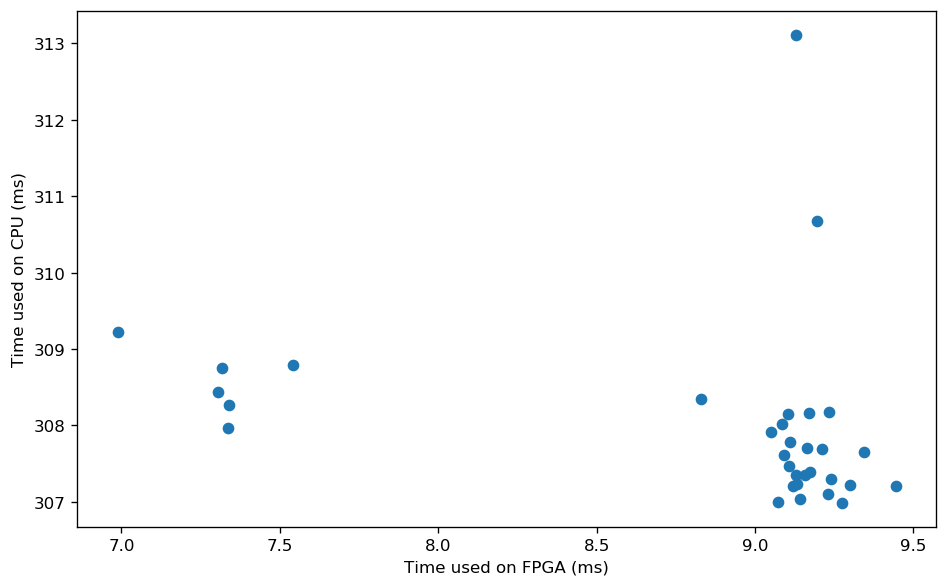

In [9]:
def stat():
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
    ax.scatter(fpga_perf, cpu_perf)
    ax.set_xlabel("Time used on FPGA (ms)")
    ax.set_ylabel("Time used on CPU (ms)")

    # x = np.linspace(int(fpga_perf.min()), int(fpga_perf.max() + 0.5), 2)
    # ax.plot(x, 6.7 * x)

    return fig


fig = stat()
fig.tight_layout()

In [10]:
# Evaluate validation accuracy
cpu_errors = 0
fpga_errors = 0
for idx in range(BATCH):
    fpga_label = np.argmax(c[idx])
    cpu_label = np.argmax(c_ref[idx])
    actual_label = np.argmax(l[idx])
    if (fpga_label!=actual_label):
        fpga_errors += 1.
    if (cpu_label!=actual_label):
        cpu_errors += 1.

# Report results
print("FPGA accuracy: {0:.2f}% validation error".format(fpga_errors/BATCH*100))
print("CPU accuracy:  {0:.2f}% validation error".format(cpu_errors/BATCH*100))
if (cpu_time < fpga_time):
    print("FPGA has a {0:.2f}x slowdown".format(fpga_time/cpu_time))
else:
    print("FPGA has a {0:.2f}x speedup".format(cpu_time/fpga_time))

FPGA accuracy: 19.96% validation error
CPU accuracy:  19.96% validation error
FPGA has a 34.94x speedup


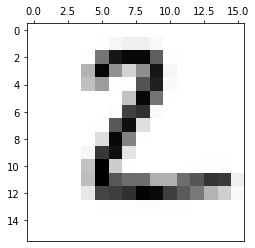

Classified as 2 by the FPGA


In [11]:
# Render a given numpy 2D array of pixel data.
def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

# Inspect one of the hand digits classified by the FPGA
idx = 1
show(i[idx].reshape(16,16))
print("Classified as {} by the FPGA".format(np.argmax(c[idx])))